In [1]:
import deepSI
from NonlinearController.systems import SinCosUnbalancedDisc, UnbalancedDisc, ReversedUnbalancedDisc, ReversedSinCosUnbalancedDisc
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter
import random
from scipy.signal import cont2discrete, lti, dlti, place_poles
import torch

In [2]:
def randomLevelReference(Nsim, nt_range, level_range):
    x_reference_list = np.array([])
    Nsim_remaining = Nsim
    while True:
        Nsim_steps = random.randint(nt_range[0],nt_range[1])
        Nsim_remaining = Nsim_remaining - Nsim_steps
        x_reference_list = np.hstack((x_reference_list, np.ones(Nsim_steps)*random.uniform(level_range[0],level_range[1])))

        if Nsim_remaining <= 0:
            x_reference_list = x_reference_list[:Nsim]
            break
    return x_reference_list

In [3]:
from torch import nn

class sincos_output_net(nn.Module):
    def __init__(self, nx, ny, nu=-1, n_nodes_per_layer=64, n_hidden_layers=2, activation=nn.Tanh):
        super(sincos_output_net, self).__init__()
        from deepSI.utils import simple_res_net
        self.ny = tuple() if ny is None else ((ny,) if isinstance(ny,int) else ny)
        self.feedthrough = nu!=-1
        if self.feedthrough:
            self.nu = tuple() if nu is None else ((nu,) if isinstance(nu,int) else nu)
            net_in = nx + np.prod(self.nu, dtype=int)
        else:
            net_in = nx
        self.net = simple_res_net(n_in=net_in, n_out=np.prod((1,),dtype=int), n_nodes_per_layer=n_nodes_per_layer, \
            n_hidden_layers=n_hidden_layers, activation=activation)

    def forward(self, x, u=None):
        xu = x
        xu = self.net(xu).view(*((x.shape[0],)+(1,)))
        y = torch.cat([torch.sin(xu), torch.cos(xu)], dim=1)
        return y
    
# change input from sin cos to arctan2 of sin cos.
    #!!! There is probably a problem with the sin and cos being normalized at the arctan2
class arctan2_encoder_net(nn.Module):
    def __init__(self, nb, nu, na, ny, nx, n_nodes_per_layer=64, n_hidden_layers=2, activation=nn.Tanh):
        super(arctan2_encoder_net, self).__init__()
        from deepSI.utils import simple_res_net
        self.nu = tuple() if nu is None else ((nu,) if isinstance(nu,int) else nu)
        self.ny = tuple() if ny is None else ((ny,) if isinstance(ny,int) else ny)
        self.net = simple_res_net(n_in=nb*np.prod(self.nu,dtype=int) + na*np.prod((1,),dtype=int), \
            n_out=nx, n_nodes_per_layer=n_nodes_per_layer, n_hidden_layers=n_hidden_layers, activation=activation)

    def forward(self, upast, ypast):
        ypast = torch.mul(torch.atan2(ypast[:,:,0],ypast[:,:,1]),0.5)
        net_in = torch.cat([upast.view(upast.shape[0],-1),ypast.view(ypast.shape[0],-1)],axis=1)
        return self.net(net_in)

class SinCos_encoder(deepSI.fit_systems.SS_encoder_general):
    def __init__(self, nx=10, na=20, nb=20, na_right=0, nb_right=0, e_net_kwargs={}, f_net_kwargs={}, h_net_kwargs={}):
        super(SinCos_encoder, self).__init__(nx=nx, na=na, nb=nb, na_right=na_right, nb_right=nb_right, e_net_kwargs=e_net_kwargs, f_net_kwargs=f_net_kwargs, h_net_kwargs=h_net_kwargs)
        self.h_net = sincos_output_net
        # self.e_net = arctan2_encoder_net
        # self.f_net = sincos_state_net

    def init_nets(self, nu, ny): # a bit weird
        na_right = self.na_right if hasattr(self,'na_right') else 0
        nb_right = self.nb_right if hasattr(self,'nb_right') else 0
        self.encoder = self.e_net(nb=(self.nb+nb_right), nu=nu, na=(self.na+na_right), ny=ny, nx=self.nx, **self.e_net_kwargs)
        self.fn =      self.f_net(nx=self.nx, nu=nu,                                **self.f_net_kwargs)
        # self.hn =      nn.Identity(self.nx)
        self.hn =      self.h_net(nx=self.nx, ny=ny,                            **self.h_net_kwargs)

    def init_model(self, sys_data=None, nu=-1, ny=-1, device='cpu', auto_fit_norm=True, optimizer_kwargs={}, parameters_optimizer_kwargs={}, scheduler_kwargs={}):
        '''This function set the nu and ny, inits the network, moves parameters to device, initilizes optimizer and initilizes logging parameters'''
        if sys_data==None:
            assert nu!=-1 and ny!=-1, 'either sys_data or (nu and ny) should be provided'
            self.nu, self.ny = nu, ny
        else:
            self.nu, self.ny = sys_data.nu, sys_data.ny
            # if auto_fit_norm:
            #     self.norm.fit(sys_data)
            self.norm.ustd = 8
            self.norm.y0 = np.array([0.0,0.0])
            self.norm.ystd = np.array([1.0,1.0])
        self.init_nets(self.nu, self.ny)
        self.to_device(device=device)
        parameters_and_optim = [{**item,**parameters_optimizer_kwargs.get(name,{})} for name,item in self.parameters_with_names.items()]
        self.optimizer = self.init_optimizer(parameters_and_optim, **optimizer_kwargs)
        self.scheduler = self.init_scheduler(**scheduler_kwargs)
        self.bestfit = float('inf')
        self.Loss_val, self.Loss_train, self.batch_id, self.time, self.epoch_id = np.array([]), np.array([]), np.array([]), np.array([]), np.array([])
        self.init_model_done = True

In [4]:
system = deepSI.load_system('NonlinearController/trained_models/sincos/sincos-test-sys_2')

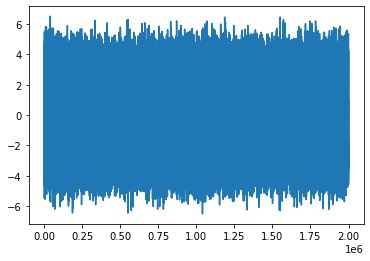

In [16]:
import NonlinearController.systems as systems

# u = np.load("NonlinearController/data/sin_perturbed_NMPC_w.npy")[0,:]
# y = np.load("NonlinearController/data/sin_perturbed_NMPC_q.npy").T
# data = deepSI.System_data(u=u, y=y)

# u = np.load("NonlinearController/data/Energy_u.npy")
# y = np.load("NonlinearController/data/Energy_y.npy")
# y = (y[:]+2*np.pi)%(2*np.pi)-np.pi
# y = np.vstack((np.sin(y),np.cos(y))).T
# data = deepSI.System_data(u=u, y=y)

Nu = 2000000; a = 2.8
u = deepSI.deepSI.exp_design.multisine(Nu, pmax=Nu//2-1, n_crest_factor_optim=1)*a/2
# u = np.clip(u, -a, a)
sigma_n = [0.014]; dt = 0.1
setup = systems.ReversedSinCosUnbalancedDisc(dt=dt, sigma_n=sigma_n)
data = setup.apply_experiment(deepSI.System_data(u=u))

plt.plot(u)

In [17]:
test_ss_enc = system.apply_experiment(data)

NRMS simulation SS linear  8.03%


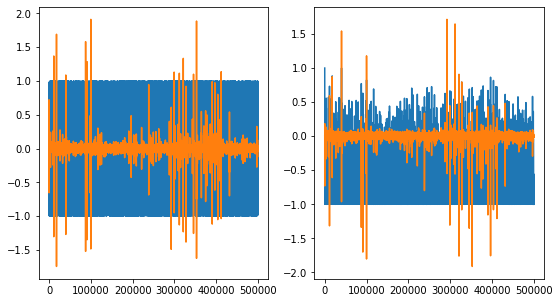

In [26]:
print(f'NRMS simulation SS linear  {test_ss_enc.NRMS(data):.2%}')
plt_len = 500000

fig1 = plt.figure(figsize=(14,5))

plt.subplot(1,3,1)
plt.plot(test_ss_enc.y[:plt_len,0], label="System")
plt.plot(test_ss_enc.y[:plt_len,0] - data.y[:plt_len,0], label='Error')

plt.subplot(1,3,2)
plt.plot(test_ss_enc.y[:plt_len,1], label="System")
plt.plot(test_ss_enc.y[:plt_len,1] - data.y[:plt_len,1], label='Error')

# plt.subplot(1,3,3)
# plt.plot(test_ss_enc.y[:,2], label="System")
# plt.plot(test_ss_enc.y[:,2] - data.y[:,2], label='Error')
# # plt.ylim((-1,1.2))

plt.show()

In [ ]:
nsteperror = system.n_step_error(data,nf=15)
plt.plot(nsteperror)